In [124]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():  
    dev = torch.device("cuda:0")
else:
    dev = torch.device("cpu")
#dev = torch.device("cpu")
print(f"Using {dev}")

Using cuda:0


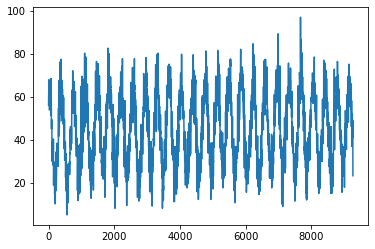

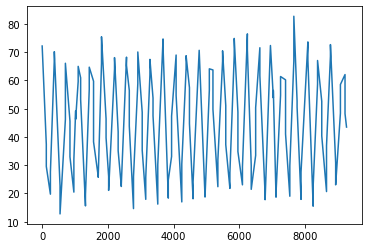

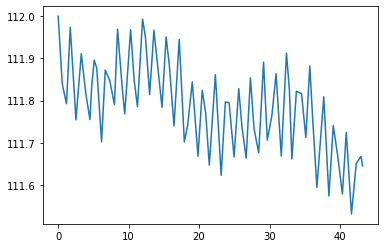

In [133]:
# ---- data loading and pre-processing ---- #

import utils.polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

torch.set_default_tensor_type('torch.cuda.FloatTensor')
# read in time series into temporary list
temp = []
f = open('DataSets/CTtemp.csv', 'r')
for line in f:
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
temp = pla.median_filter(temp, 5)
data, max_len = pla.sliding_window_pla(temp,6000)
pla.display_trends(data, 112)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 4
train_proportion = 0.7

# segment the data into input output pairs that we will use to train the model
'''def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        inputs.append(data[i:(i+seq_length*2)]) # the next n are the input
        outputs.append(data[i+seq_length*2+1:i+seq_length*2+2]) # and the one after that is the output
    return Variable(torch.cuda.FloatTensor(np.array(inputs)).to(dev)), Variable(torch.cuda.FloatTensor(np.array(outputs)).to(dev))'''

def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        temp = data[i:(i+seq_length*2)]
        new = []
        for x in range(0,len(temp),2):
            new.append([temp[x],temp[x+1]])
        inputs.append(new)
        outputs.append(data[i+seq_length*2+1:i+seq_length*2+2]) # and the one after that is the output
    return Variable(torch.cuda.FloatTensor(np.array(inputs)).to(dev)), Variable(torch.cuda.FloatTensor(np.array(outputs)).to(dev))

'''def sliding_window(data):
    seq_length = 4
    seq_length *= 2
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length, 2):
        inputs.append(np.array(data[i:(i+seq_length)]).reshape(int(seq_length/2),2))
        outputs.append(np.array(data[i+seq_length+1:i+seq_length+2]))
    return Variable(torch.cuda.FloatTensor(inputs).to(dev)), Variable(torch.cuda.FloatTensor(outputs).to(dev))'''

    # convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size)

validation_index = int((len(total_data_input) - train_size)*0.5) #Calculates how many data points in the validation set
testing_index = len(total_data_input) - train_size - validation_index

validation_data_input = torch.narrow(total_data_input, 0, train_size, validation_index).to(dev)
validation_data_output = torch.narrow(total_data_output, 0, train_size, validation_index).to(dev)

testing_data_input = torch.narrow(total_data_input, 0, train_size+validation_index, testing_index).to(dev)
testing_data_output = torch.narrow(total_data_output, 0, train_size+validation_index, testing_index).to(dev)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
validate = torch.utils.data.TensorDataset(validation_data_input, validation_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)

trainset = torch.utils.data.DataLoader(train, batch_size=256, shuffle=False)
validateset = torch.utils.data.DataLoader(validate, batch_size=256, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=256, shuffle=False)

In [138]:
from models import MLP, TCN, CNN, RNN, LSTM, BiLSTM
model = CNN(seq_length, 128, 0.1, 2).to(dev)
#model = LSTM(1,2,64,1,0.5)
print(model)

LSTM(
  (LSTM): LSTM(2, 64, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


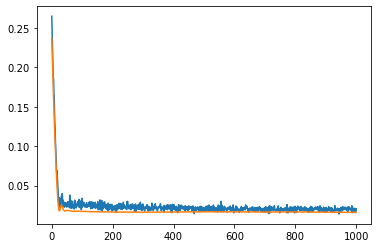

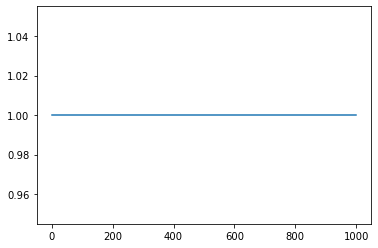

Lowest validation loss: 0.016053874045610428 at epoch 974


In [139]:
epochs = 1000
learning_rate = 0.001
import torch.optim as optim
train_loss = []
validation_loss = []
model.train()
epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 9999999 # the lowest validation loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
validation_direction_accuracy = []

for epoch in range(epochs+1):

    epoch_total_trainloss = 0 # reset this for the validation epoch'''
    model.train()
    for data in trainset:  # for each batch
        features, labels = data  # split the batches up into their features and labels
        model.zero_grad()
        output = model(features) # get a prediction from the model
        output = output
        #print(output.shape)
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)
        torch.cuda.synchronize()
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch

    # now we'll calculate the direction accuracy for the training and validation sets
    correct=0
    total_points = 0
    model.eval()
    for data in validateset:
        
        inputs, labels = data
        output = model(inputs)
        total_points += len(output)
        for i in range(len(output)):
            pred = output[i]
            actual = labels[i]
            if pred < 0 and actual < 0 or pred > 0 and actual > 0: #or (pred-actual)<0.01:
                correct += 1
            #print(output[0],labels[0])
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        epoch_total_trainloss += loss.item()/len(validateset)
        torch.cuda.synchronize()
    
    if epoch_total_trainloss < min_val_loss:
        #torch.save(model.state_dict(), 'TCN temp.pt')
        min_val_loss = epoch_total_trainloss
        min_val_loss_epoch = epoch
    validation_direction_accuracy.append(correct/(total_points))
    validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")

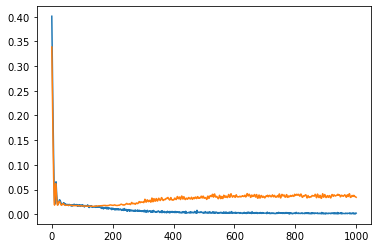

NameError: name 'net' is not defined

In [128]:
# test
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()

with torch.no_grad():
    correct = 0
    i = 0
    X, Y = [], []
    X2, Y2 = [], []
    total_loss = 0
    output_file = open("angles.txt", "w")
    for data in train:
        inputs, labels = data
        output = net(inputs.view(-1,seq_length*2))
        output_file.write(str(output.item()*90) + "\n")
        net.zero_grad()

    for data in test:
        inputs, labels = data
        output = net(inputs.view(-1,seq_length*2))
        output_file.write(str(output.item()*90) + "\n")
        net.zero_grad()
        total_loss += F.mse_loss(output[0], labels).item()
        output = output[0]
        if output[0] < 0 and labels[0] < 0 or output[0] > 0 and labels[0] > 0:
            correct += 1
            #print(output[0],labels[0])
    print(f'Directional Accuracy: {correct*100/len(test)}, Average Loss: {total_loss/len(test)}')


